In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict


In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [4]:
X_train_orig.shape

(1080, 64, 64, 3)

In [5]:
Y_train_orig.shape

(1, 1080)

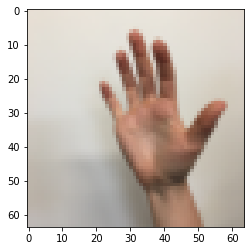

In [19]:
plt.imshow(X_test_orig[10])

In [21]:
Y_test_orig.shape

(1, 120)

In [9]:
 classes

array([0, 1, 2, 3, 4, 5])

In [28]:
# Flatten the training and test images
#That is of making Nx vector shape(shape[1]*shape[2]*shape[3],shape[0]) often write as given
#both are right 
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

In [29]:
X_train_flatten.shape

(12288, 1080)

In [46]:
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.


In [47]:
X_train.shape

(12288, 1080)

In [48]:
X_test.shape

(12288, 120)

In [31]:
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

In [51]:
Y_train.shape

(6, 1080)

In [52]:
Y_test.shape

(6, 120)

In [44]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    
    return X, Y

In [45]:
# are going use Xavier Initialization for weights and Zero Initialization for biases:
def initialize_parameters():
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [25, 12288], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer = tf.zeros_initializer())
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [57]:
def forward_propagation(X, parameters):

    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    print("size of",W1.shape)
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                            # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    return Z3

In [58]:
def compute_cost(Z3, Y):
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [59]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

W0510 01:14:20.264609 140689653176128 deprecation.py:323] From <ipython-input-58-86fea8b55355>:18: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



size of (25, 12288)
Cost after epoch 0: 1.913693
Cost after epoch 100: 1.049044
Cost after epoch 200: 0.756096
Cost after epoch 300: 0.590979
Cost after epoch 400: 0.483216
Cost after epoch 500: 0.393141
Cost after epoch 600: 0.323622
Cost after epoch 700: 0.261636
Cost after epoch 800: 0.210272
Cost after epoch 900: 0.171655
Cost after epoch 1000: 0.151218
Cost after epoch 1100: 0.110638
Cost after epoch 1200: 0.089408
Cost after epoch 1300: 0.061200
Cost after epoch 1400: 0.053925


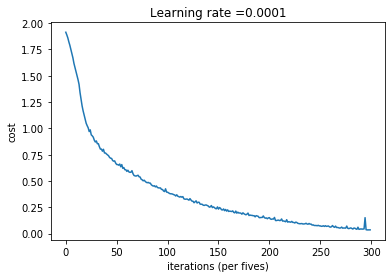

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [60]:
parameters = model(X_train, Y_train, X_test, Y_test)

Your algorithm predicts: y = 4


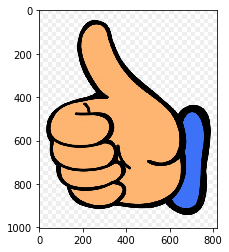

In [80]:
import cv2 

## (PUT YOUR IMAGE NAME) 
my_image = "th.jpg"

# We preprocess your image to fit your algorithm.
fname = my_image
image = np.array(plt.imread(fname))
image = image/255.
my_image = cv2.resize(image,(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))